<center>
<h1>Variational Auto encoders and decoders</h1>
<h2>Pokemon datasets</h2>
</center>

**Name:** ``Sankhya Singh``
<br>

---



In [1]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

GeForce 940MX


## 1a. Encoder 

We will use a multi-layer perceptron to implement the encoder. In PyTorch each layer of a multi-layer perceptron is implemented using a `Linear` layer followed by an activation function layer (e.g., `ReLU` or `Tanh`). Often a `BatchNorm1d` layer is inserted between the `Linear` layer and activation function to improve training.We implement a two-layer perceptron of the following architecture:

```
Linear -> BatchNorm1d -> ReLU -> Linear -> Tanh

|---------------------------|    |------------|
        hidden layer              output layer
```

The hidden layer and output layer should both have dimensionality `z_dim`-by-1-by-1.

In [3]:
###########################################################################
# TODO: Write any helper routines for the Encoder here.                   #
###########################################################################


###########################################################################
# TODO: Complete the Encoder.                                             #
###########################################################################

class Encoder(nn.Module):
    """Encoder network to map from an RGB image to a latent feature vector."""

    def __init__(self, z_dim=64, img_size=64):
        super(Encoder, self).__init__()

        self.z_dim = z_dim
        self.hidden_layer = nn.Sequential(nn.Linear(img_size*img_size*3,128),nn.BatchNorm1d(128),nn.ReLU(True))
        self.output_layer = nn.Sequential(nn.Linear(128,128),nn.Tanh())

        


    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.output_layer(self.hidden_layer(x))
        return x


## 2b. Decoder 

The decoder is implemented as a sequence of transposed and regular convolutions. The transposed convolutions have the effect of incrementally upsampling from the `z_dim`-by-1-by-1 latent representation (input to the first layer) to the 3-by-64-by-64 image (output of the last layer). The regular convolutions smooth the upsampled output.We implement the following architecture:

```
 (L1) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L2) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L3) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L4) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> Tanh
```

The specification for each layer is as follows:

<table>
    <tr>
        <td></td><td colspan=3><tt>ConvTransposed2d</tt></td><td colspan=4><tt>Conv2d</tt></td>
    </tr>
    <tr>
        <td></td><td>Filters</td><td>Kernel</td><td>Stride</td><td>Filters</td><td>Kernel</td><td>Stride</td><td>Padding</td>
    </tr>
    <tr>
        <td>Layer #1</td><td>64</td><td>15</td><td>1</td><td>64</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #3</td><td>32</td><td>3</td><td>2</td><td>32</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #4</td><td>16</td><td>3</td><td>2</td><td>16</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #5</td><td>16</td><td>2</td><td>1</td><td>3</td><td>1</td><td>1</td><td>N</td>
    </tr>    
<table>

We will assume that images are always 64-by-64 pixels.

In [4]:


###########################################################################
# TODO: Complete the Decoder.                                             #
###########################################################################

class Decoder(nn.Module):
    """Decoder network to map from a latent feature vector to an RGB image."""

    def __init__(self, z_dim=64, img_size=64):
        super(Decoder, self).__init__()

        assert img_size==64
        self.z_dim = z_dim
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(128,64,15,stride=1),nn.BatchNorm2d(64),nn.ReLU(True),nn.Conv2d(64,64,3,stride=1,padding=1),nn.BatchNorm2d(64),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(64,32,3,stride=2),nn.BatchNorm2d(32),nn.ReLU(True),nn.Conv2d(32,32,3,stride=1,padding=1),nn.BatchNorm2d(32),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(32,16,3,stride=2),nn.BatchNorm2d(16),nn.ReLU(True),nn.Conv2d(16,16,3,stride=1,padding=1),nn.BatchNorm2d(16),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(16,16,2,stride=1),nn.BatchNorm2d(16),nn.ReLU(True),nn.Conv2d(16,3,1,stride=1,padding=0),nn.BatchNorm2d(3),nn.Tanh())

        ####################################################################
        # TODO: Create a nn.Sequential model for each layer in the decoder #
        # as described in the assignment specification. Assign them to     #
        # self.layer1, self.layer2, etc. The unit tests below will help    #
        # you check that you got the layers correct.                       #
        ####################################################################
        


    def forward(self, x):
        x = x.view(x.size()[0], self.z_dim, 1, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


# 3. Experiments 

The code will run on a GPU if one is available and the appropriate cuda libraries are installed. Otherwise it will run on the CPU (and take much longer for training).

The code will create a directory called `samples` and save a subset of reconstructed and randomly generated images there during training.

<IPython.core.display.Javascript object>


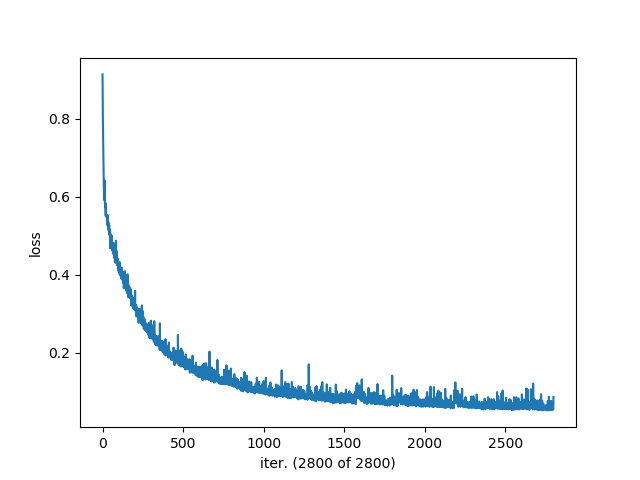

Moving models to GPU.
Started training at Fri Oct 30 19:58:41 2020
Saved samples\sample-000100.png
Saved samples\novel-000100.png
Saved samples\sample-000200.png
Saved samples\novel-000200.png
Saved samples\sample-000300.png
Saved samples\novel-000300.png
Saved samples\sample-000400.png
Saved samples\novel-000400.png
Saved samples\sample-000500.png
Saved samples\novel-000500.png
Saved samples\sample-000600.png
Saved samples\novel-000600.png
Saved samples\sample-000700.png
Saved samples\novel-000700.png
Saved samples\sample-000800.png
Saved samples\novel-000800.png
Saved samples\sample-000900.png
Saved samples\novel-000900.png
Saved samples\sample-001000.png
Saved samples\novel-001000.png
Saved samples\sample-001100.png
Saved samples\novel-001100.png
Saved samples\sample-001200.png
Saved samples\novel-001200.png
Saved samples\sample-001300.png
Saved samples\novel-001300.png
Saved samples\sample-001400.png
Saved samples\novel-001400.png
Saved samples\sample-001500.png
Saved samples\novel

In [6]:
import os
import time

# Run on GPU if available. Set to False if you want to force the models
# to stay on the CPU even if cuda is available.
RUN_ON_GPU = torch.cuda.is_available()

# Set the random seed for reproducibility
SEED = 4680

np.random.seed(SEED)
torch.manual_seed(SEED)
if RUN_ON_GPU:
    torch.cuda.manual_seed(SEED)


def np_to_var(x):
    """Converts numpy to variable."""
    if RUN_ON_GPU:
        x = x.cuda()
    return Variable(x)


def var_to_np(x):
    """Converts variable to numpy."""
    if RUN_ON_GPU:
        x = x.cpu()
    return x.data.numpy()


def get_data_loader(image_size=64, batch_size=16):
    """Creates training data loader."""
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    transforms.RandomHorizontalFlip(0.5)
                ])

    train_dataset = datasets.ImageFolder('./data/', transform)
    return DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


# --- training code -------------------------------------------------------

def create_models(image_size=64, latent_size=128):
    """Creates encoder and decoder and moves them to the GPU if requested."""

    E = Encoder(latent_size, image_size)
    D = Decoder(latent_size, image_size)

    if RUN_ON_GPU:
        print('Moving models to GPU.')
        E.cuda()
        D.cuda()
    else:
        print('Keeping models on CPU.')

    return E, D


def train_models(E, D, image_size=64, latent_size=128, batch_size=32, num_epochs=400,
                 log_interval=10, save_interval=100, out_dir='samples', plot_fcn=None):
    """Train models."""

    # create optimizers
    e_optimizer = optim.Adam(E.parameters(), 1.0e-3, [0.5, 0.999])
    d_optimizer = optim.Adam(D.parameters(), 2.0e-3, [0.5, 0.999])

    # create output directory for image samples
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    dataloader = get_data_loader(image_size=image_size, batch_size=batch_size)
    total_train_iters = num_epochs * len(dataloader)

    loss_history = []
    print('Started training at {}'.format(time.asctime(time.localtime(time.time()))))

    # train for num_epochs
    for epoch in range(num_epochs):
        for iteration, batch in enumerate(dataloader, epoch * len(dataloader) + 1):

            real_images, _ = batch
            noisy_images = torch.clamp(torch.add(real_images, 2.0 * (torch.rand(real_images.size()) - 0.5)), min=-1.0, max=1.0)
            real_images = np_to_var(real_images)
            noisy_images = np_to_var(noisy_images)

            e_optimizer.zero_grad()
            d_optimizer.zero_grad()
            out_images = D.forward(E.forward(noisy_images))
                        
            # compute reconstruction loss and update parameters
            loss = torch.mean((real_images - out_images).abs())
            loss.backward()
            e_optimizer.step()
            d_optimizer.step()

            # keep track of loss for plotting or printing
            loss_history.append(loss.data.item())

            # print the log info
            if iteration % log_interval == 0:
                if plot_fcn is None:
                    print('Iteration [{:6d}/{:6d}] | loss: {:.4f}'.format(
                        iteration, total_train_iters, loss_history[-1]))
                else:
                    plot_fcn(loss_history, total_train_iters)

            # save the generated samples and loss
            if iteration % save_interval == 0:
                path = os.path.join(out_dir, 'sample-{:06d}.png'.format(iteration))
                torchvision.utils.save_image(torch.cat((real_images, noisy_images, out_images)),
                                             path, nrow=real_images.size()[0], normalize=True)
                print('Saved {}'.format(path))

                # generate and save some novel images
                noise = np_to_var(2.0 * (torch.rand((batch_size, latent_size, 1, 1)) - 0.5))
                novel_images = D.forward(noise)
                path = os.path.join(out_dir, 'novel-{:06d}.png'.format(iteration))
                torchvision.utils.save_image(novel_images, path, normalize=True)
                print('Saved {}'.format(path))
                
    print('Finished training at {}'.format(time.asctime(time.localtime(time.time()))))                
    return loss_history
                
# --- main ----------------------------------------------------------------

fig, ax = plt.subplots(1,1)

def plot_loss(loss, x_max=None):
    """Loss plotting."""
    ax.clear()
    ax.plot(loss)
    if x_max is not None:
        ax.set_xlabel('iter. ({} of {})'.format(len(loss), x_max))
    else:
        ax.set_xlabel('iter.')
    ax.set_ylabel('loss')
    fig.canvas.draw()

latent_size = 128
E, D = create_models(64, latent_size)
loss_curve = train_models(E, D, image_size=64, latent_size=latent_size, batch_size=32, num_epochs=400,
    log_interval=10, save_interval=100, out_dir='samples', plot_fcn=plot_loss)